In [83]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace,read_inventory,read_events
from obspy.io.sac.sactrace import SACTrace
from obspy.imaging.beachball import beachball,beach
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta

import os
from glob import glob
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import signal
import subprocess
from sklearn import preprocessing
import geopy.distance
from scipy.spatial.distance import cosine


#para plotar as figuras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,FixedLocator,StrMethodFormatter
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing
from matplotlib.patches import Rectangle

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import requests
import csv
import xml.etree.ElementTree as ET
import ast

# INPUT DATA

In [11]:
EVENT_GLIDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS_GLIDERS/'
EVENT_RSBR = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/DATA_EVENTS/'
QUAKEXML_FOLDER = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/EVENTS/'
FOLDER_OUTPUT = '/home/sysop/dados_posdoc/GLIDER_PETROBRAS/OUTPUT/'

In [32]:
def energy_ratio(a, nsta):
    r"""
    Energy ratio detector.

    Energy ratio defined as

    .. math::
        \text{er}(i) = \frac{\sum_{j=i}^{i+L}{a_j^2}}{\sum_{j=i-L}^{i}{a_j^2}}

    where :math:`L` is ``nsta``.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of the energy ratio window in samples. It's the same
                 length as ``nsta`` in the classical STA/LTA methods.
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Energy Ratio

    .. seealso:: [Han2009]_
    """
    if nsta > len(a) // 2:
        # Half forward, half backward -> empty medium
        msg = (
            f'nsta ({nsta}) must not be larger than half the length of the '
            f'data ({len(a)} samples).')
        raise ValueError(msg)
    if nsta <= 0:
        # If nsta is zero, the sum is undefined
        msg = f'nsta ({nsta}) must not be equal to or less than zero.'
        raise ValueError(msg)
    sig_power = np.r_[0, np.cumsum(a ** 2, dtype=np.float64)]
    energy_diff = sig_power[nsta:] - sig_power[:len(sig_power) - nsta]
    er = np.zeros(len(a), dtype=np.float64)
    np.divide(energy_diff[nsta:], energy_diff[:len(energy_diff) - nsta],
              where=energy_diff[:len(energy_diff) - nsta] != 0,
              out=er[nsta:len(er) - nsta + 1])
    return er

def modified_energy_ratio(a, nsta, power=3):
    r"""
    Modified energy ratio detector.

    Improvement of the :func:`energy_ratio` that accounts for the signal
    itself:

    .. math::
        \text{mer}(i) = (\text{er}(i) * |a(i)|)^3

    where :math:`text{er}(i)` is the :func:`energy_ratio`.

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of energy ratio window in samples. It's the same length
                 as ``nsta`` in the classical STA/LTA methods.
    :type power: int
    :param power: The power exponent in the equation above. Default: 3
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Modified Energy Ratio
    """
    er = energy_ratio(a, nsta=nsta)
    mer = np.power(er * np.abs(a), power, out=er)
    return mer

In [33]:
files_lfi_rsbr = glob('*.2017.*')

In [35]:
cat = obspy.read_events(QUAKEXML_FOLDER+'CMTSOLUTIONS.xml')
cat

781 Event(s) in Catalog:
2021-12-29T18:26:00.000000Z |  -7.690, +127.560 | 7.32 mw
2021-12-26T15:43:01.700000Z | -18.060, -179.360 | 6.14 mw
...
2015-11-07T07:04:41.800000Z | -29.540,  -72.330 | 6.05 mw
2015-11-04T03:44:21.200000Z |  -8.200, +124.950 | 6.54 mw
To see all events call 'print(CatalogObject.__str__(print_all=True))'

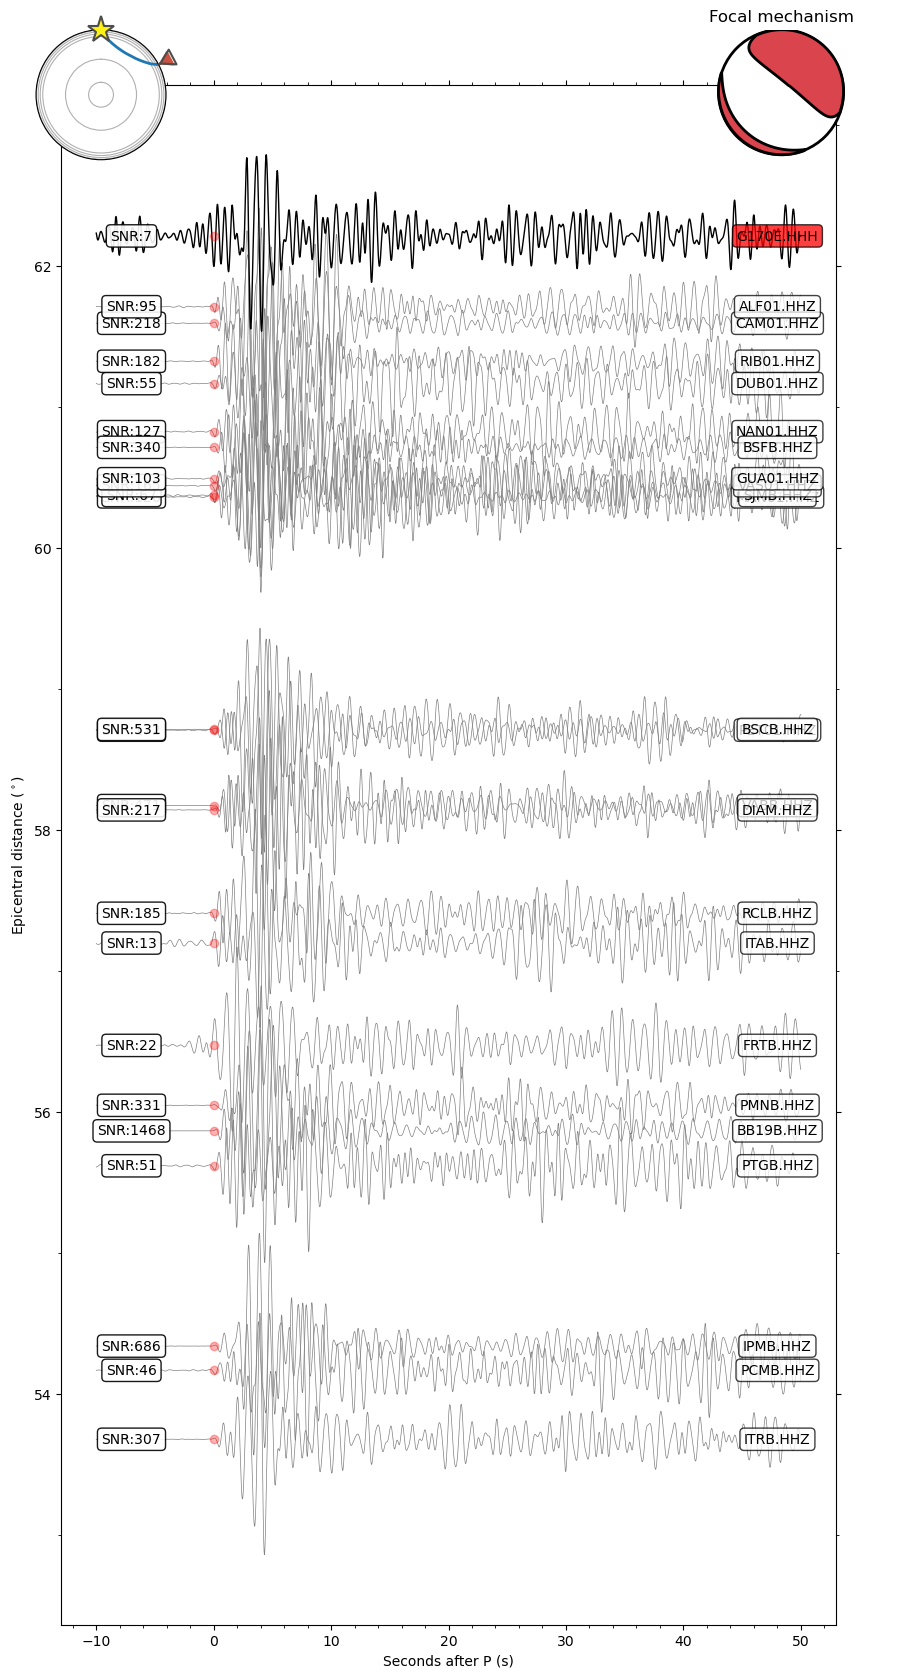

In [69]:
# set up the plot and create a GeoAxes:
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot()
        
# ============= #
# RSBR STATIONS
# ============= #
for st_file in rsbr:
    st_plot = obspy.read(st_file)[0]
                
    gcarc = st_plot.stats.sac.gcarc
    df = st_plot.stats.sampling_rate
        
    st_plot.filter('bandpass',freqmin=1,freqmax=2, corners=4, zerophase=False)
    st_plot.taper(max_percentage=0.3, type='cosine')      
    st_plot.detrend('linear')
    st_plot.detrend('demean')

    cft = modified_energy_ratio(a=st_plot.data,nsta=int(3 * df), power=3)
    st_plot.trim(st_plot.times('utcdatetime')[cft.argmax()]-10,st_plot.times('utcdatetime')[cft.argmax()]+50)
        
    ax.plot(st_plot.times()[1000]-10,gcarc,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)                   
    ax.plot(st_plot.times()-10,gcarc+preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5)
    ax.text(x=st_plot.times()[-200]-10,y=st_plot.stats.sac.gcarc,s=st_plot.stats.station+'.'+st_plot.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.75))
    
    # ----------------------------------------------------------------------------------------------------------
    # SNR P-wave
    # ----------------------------------------------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # Retrieving the P-wave normalized amplitude between -x and +x seconds

    amp_P = st_plot.data[1000:1500]
    
    # -------------------------------------------------------------------
    # Retrieving the noise normalized amplitude between -x and +x seconds

    noise_amp = st_plot.data[400:900]
        
    # ---------------
    # Evaluating: SNR
                                            
    powS = np.mean(np.abs(amp_P))
    powN = np.mean(np.abs(noise_amp))
    
    snr = powS/powN
    snr = round(snr)

    ax.text(x=st_plot.times()[300]-10,y=gcarc,s='SNR:'+str(snr),ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.9))           


for st_file_glider in glider:
    st_plot_glider = obspy.read(st_file_glider)[0]
        
    gcarc_glider = st_plot_glider.stats.sac.gcarc
    df = st_plot_glider.stats.sampling_rate

            
    st_plot_glider.filter('bandpass',freqmin=1,freqmax=2, corners=4, zerophase=False)
    st_plot_glider.taper(max_percentage=0.3, type='cosine')      
    st_plot_glider.detrend('linear')
    st_plot_glider.detrend('demean')

    cft_glider = modified_energy_ratio(a=st_plot_glider.data,nsta=int(4 * df), power=3)
    st_plot_glider.trim(st_plot_glider.times('utcdatetime')[cft_glider.argmax()]-10,st_plot_glider.times('utcdatetime')[cft_glider.argmax()]+50)
        
    ax.plot(st_plot_glider.times()[1000]-10,gcarc_glider,c='r',marker='o',alpha=0.3,label='P arrival',zorder=10)                   
    ax.plot(st_plot_glider.times()-10,gcarc_glider+preprocessing.normalize([st_plot_glider.data])[0]*10,c='k',ls='-',lw=1)
    ax.text(x=st_plot_glider.times()[-200]-10,y=st_plot_glider.stats.sac.gcarc,s=st_plot_glider.stats.station+'.'+st_plot_glider.stats.channel,ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='r',alpha=0.75))

    # ----------------------------------------------------------------------------------------------------------
    # SNR P-wave
    # ----------------------------------------------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # Retrieving the P-wave normalized amplitude between -x and +x seconds

    amp_P = st_plot_glider.data[1000:1500]
    
    # -------------------------------------------------------------------
    # Retrieving the noise normalized amplitude between -x and +x seconds

    noise_amp = st_plot_glider.data[400:900]
        
    # ---------------
    # Evaluating: SNR
                                            
    powS = np.mean(np.abs(amp_P))
    powN = np.mean(np.abs(noise_amp))
    
    snr = powS/powN
    snr = round(snr)

    ax.text(x=st_plot_glider.times()[300]-10,y=gcarc_glider,s='SNR:'+str(snr),ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.9))           
            
ax.set_ylabel('Epicentral distance ($^\circ$)')
ax.set_xlabel('Seconds after P (s)')
#ax.legend(loc='lower right')
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# ----------------------------------------------------------------------------------------------------------
# focal mechanisms
# ----------------------------------------------------------------------------------------------------------

ev_lat = st_plot_glider.stats.sac.evla
ev_long = st_plot_glider.stats.sac.evlo
ev_depth = st_plot_glider.stats.sac.evdp
magnitude = st_plot_glider.stats.sac.mag
magnitude_type = 'mw'

time_ev = UTCDateTime.strptime(st_file_glider[9:-6],format='%Y.%j.%H.%M.%S')
cat2 = cat.filter("time >= "+UTCDateTime.strftime(time_ev-60,format='%Y-%m-%dT%H:%M:%S'),"time <= "+UTCDateTime.strftime(time_ev+60,format='%Y-%m-%dT%H:%M:%S'))

# Plotting: graphical representation of a focal mechanism (https://docs.obspy.org/packages/autogen/obspy.imaging.beachball.beachball.html)

# Normalize event depth values between 0 and 600 km:
min_val = 0
max_val = 600
normalized_values = [(x - min_val) / (max_val - min_val) for x in np.arange(min_val, max_val,10)]

# Colormap "Plasma" for each value
colors = [plt.cm.Spectral(value) for value in normalized_values]
                                                                        
# Convert colors RGB to hexadecimal:
hex_colors = [mcolors.rgb2hex(color) for color in colors]

# Find the color for a given depth
diff_ev_depth = [np.abs(numero - ev_depth) for numero in np.arange(min_val, max_val,10)]
                                        
# Find the min index for a given depth
index_min_ev_depth = diff_ev_depth.index(min(diff_ev_depth))
    
# -------------------------
newax = fig.add_axes([0.72, 0.72, 0.25,  0.25])
    
moment_tensor = cat2[0].focal_mechanisms[0].moment_tensor.tensor
mrr = moment_tensor.m_rr
mtt = moment_tensor.m_tt
mpp = moment_tensor.m_pp
mrt = moment_tensor.m_rt
mrp = moment_tensor.m_rp
mtp = moment_tensor.m_tp
mt = [mrr, mtt, mpp, mrt, mrp, mtp]
    
# Plotting the hexcolor
bball = beach(fm=mt, xy=(0, 0.5),size=500, width=1, facecolor=hex_colors[index_min_ev_depth])

# Configura os eixos e adiciona a coleção
newax.add_collection(bball)
newax.set_xlim(-1, 1)
newax.set_ylim(-1, 1)
newax.set_aspect('equal')
newax.axis('off')
newax.set_title('Focal mechanism')

# ===========================================================
# ray paths (https://docs.obspy.org/packages/obspy.taup.html)
# ===========================================================

#Calculating distance, azimuth and backazimuth
model = TauPyModel(model='ak135')

# ---------------------------------------------------------------------------------------------------
# Computing: The paths travelled by the rays to the receiver for a given phase and 1D velocity model 
                    
arrivals_ray_path = model.get_ray_paths(source_depth_in_km=ev_depth, distance_in_degree=gcarc_glider, phase_list=['P'])

# -------------------------
# Plotting: axes parameters 
                                    
ax_raypath = fig.add_axes([0.1, 0.81, 0.13,  0.13], projection='polar')
arrivals_ray_path.plot_rays(ax=ax_raypath)
ax_raypath.set_title('Ray path',y=1.08)

# ----------------------------------------------------------------------------------------------------------
# Title
ax.set_title(cat2[0].origins[0].region.title()+'\n '+cat2[0].origins[0].time.strftime('%Y-%m-%dT%H:%M:%S')+' Dep: '+str(round(ev_depth))+' km'+'\n Mag: '+str(cat2[0].magnitudes[0].mag)+' '+cat2[0].magnitudes[0].magnitude_type+'\n ',fontsize=20)

# ----------------------------------------------------------------------------------------------------------
# Saving figure
fig.savefig('event_GL_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+cat2[0].event_descriptions[0].text+'.png',pad_inches=0.0,dpi=200)
#plt.close()

In [95]:
from scipy.spatial.distance import cosine

similarity = []

st_plot_lst = []
st_plot_glider_lst = []
for st_file in rsbr:
    st_plot = obspy.read(st_file)[0]
    st_plot_glider = obspy.read(glider[0])[0]

    for tr in [st_plot,st_plot_glider]:
           
        tr.filter('bandpass',freqmin=1,freqmax=2, corners=4, zerophase=False)
        tr.taper(max_percentage=0.2, type='cosine')      
        tr.detrend('linear')
        tr.detrend('demean')
    
        cft = modified_energy_ratio(a=tr.data,nsta=int(4 * df), power=3)
        tr.trim(tr.times('utcdatetime')[cft.argmax()]-2,tr.times('utcdatetime')[cft.argmax()]+8)


    # Distância DTW
    Cosseno = 1 - cosine(st_plot.data, st_plot_glider.data)

    if round(abs(Cosseno),2) > 0.5:
        similarity.append(round(abs(Cosseno),2))
        st_plot_lst.append(st_plot)
        st_plot_glider_lst.append(st_plot_glider)

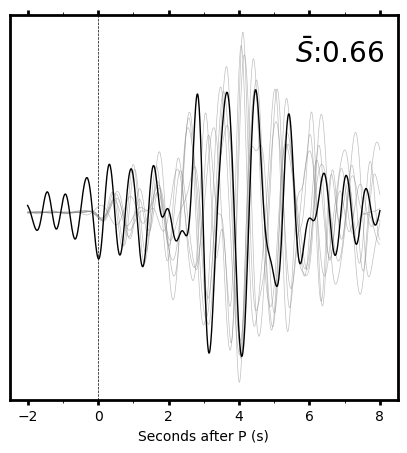

In [153]:
# set up the plot and create a GeoAxes:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
        
# ============= #
# RSBR STATIONS
# ============= #
for st_plot in st_plot_lst:
                
    gcarc = st_plot.stats.sac.gcarc
    df = st_plot.stats.sampling_rate
               
    ax.plot(st_plot.times()-2,preprocessing.normalize([st_plot.data])[0]*10,c='grey',ls='-',lw=0.5,alpha=0.5)
    
    # ----------------------------------------------------------------------------------------------------------
    # SNR P-wave
    # ----------------------------------------------------------------------------------------------------------
    
    # --------------------------------------------------------------------
    # Retrieving the P-wave normalized amplitude between -x and +x seconds

    amp_P = st_plot.data[1000:1500]
    
    # -------------------------------------------------------------------
    # Retrieving the noise normalized amplitude between -x and +x seconds

    noise_amp = st_plot.data[400:900]
        
    # ---------------
    # Evaluating: SNR
                                            
    powS = np.mean(np.abs(amp_P))
    powN = np.mean(np.abs(noise_amp))
    
    snr = powS/powN
    snr = round(snr)

ax.plot(st_plot_glider_lst[0].times()-2,preprocessing.normalize([st_plot_glider_lst[0].data])[0]*10,c='k',ls='-',lw=1)
ax.axvline(x=0,ymin=0,ymax=1,c='k',lw=0.5,ls='--')
ax.text(0.85, 0.9,r'$\bar{S}$:'+str(round(np.mean(similarity),2)), transform=ax.transAxes, fontsize=20, ha='center', va='center')

ax.set_xlabel('Seconds after P (s)')
ax.set_yticks([])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_ticks_position('both')

# Ajustando a largura das bordas do mapa
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Ajustando a largura das linhas dos ticks nos eixos
ax.tick_params(width=2)
# ----------------------------------------------------------------------------------------------------------
# Saving figure
fig.savefig('event_GL_'+time_ev.strftime('%Y-%m-%dT%H:%M:%S')+'_'+cat2[0].event_descriptions[0].text+'_correlation.png',pad_inches=0.0,dpi=200)
#plt.close()

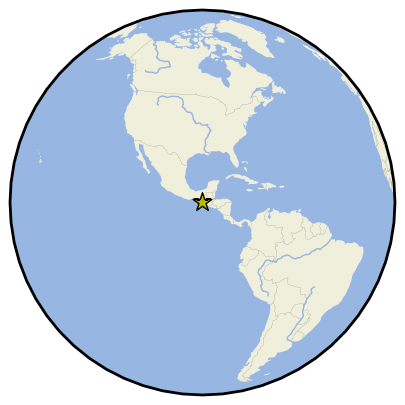

In [144]:
fig = plt.figure(figsize=(10, 5))

# Definindo globalmente o tamanho da fonte
mpl.rcParams.update({'font.size': 10})

#####################################################
# Adding MAP 
#####################################################

proje = ccrs.Orthographic(central_longitude=st_plot.stats.sac.evlo, central_latitude=st_plot.stats.sac.evla)
ax = fig.add_subplot(1, 1, 1, projection=proje)

# Adicionando recursos ao mapa
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='--', lw=0.1)
ax.add_feature(cfeature.RIVERS)


ax.set_global()  # Certifica-se de incluir todo o globo, ou remova se for desnecessário

# Plotando a estrela na posição correta
ax.scatter(st_plot.stats.sac.evlo,st_plot.stats.sac.evla,c='y',marker='*',edgecolor='k',s=200,transform=ccrs.PlateCarree())

# Ajustando a largura das bordas do mapa
for spine in ax.spines.values():
    spine.set_linewidth(2)


fig.savefig('map_event.png',pad_inches=0.0,dpi=200,transparent=True)


In [ ]:
from obspy.signal.trigger import plot_trigger

for i in sorted(rsbr):
    a = obspy.read(i)
    a.filter('bandpass',freqmin=1,freqmax=2, corners=4, zerophase=False)
    a.taper(max_percentage=0.3, type='cosine')      
    a.detrend('linear')
    a.detrend('demean')
    trace = a[0]    
    df = trace.stats.sampling_rate

    try:
        cft = modified_energy_ratio(a=trace.data,nsta=int(4 * df), power=3)
        fig, axes = plot_trigger(trace, cft, cft.max()*0.9, 0.1)
        
        axes[0].text(x=trace.times()[cft.argmax()],y=trace.data[cft.argmax()],s='P',ha="center",va="center",bbox=dict(boxstyle="round",ec='k',fc='w',alpha=0.5))
        axes[1].set_yscale('log')
        axes[1].set_ylim(ymin=0.01)
    except:
        pass
     